# Performance analysis

Importing libraries:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import seaborn as sns
import math
import numpy as np

import warnings
warnings.filterwarnings("ignore")

MACHINE_ID = {2:'numa', 3:'cluster node'}
MACHINE_SPEC = {'pc':'Intel Core i7-10750H', 'numa':'spmnuma.unipi.it', 'cluster':'spmcluster.unipi.it'}
LOG_DIR = pathlib.Path('./log_single_proc')
PLOT_DIR = pathlib.Path('./plots_single_proc')

BLUE_PALETTE = ['#142459', '#176BA0', '#19AADE', '#1AC9E6', '#1AC9E6']
PURPLE_PALETTE = ['#30076C', '#7D3AC1', '#AF48CE', '#D36CF2', '#EB549C']
ORANGE_PALETTE = ['#820401', '#C02323', '#DE542C', '#EF7E12' , '#EE9A3A']
GREEN_PALETTE = ['#164B32', '#2E7150', '#44996F', '#6DC296', '#A0E2B6']
PALETTE = [PURPLE_PALETTE, GREEN_PALETTE, ORANGE_PALETTE, BLUE_PALETTE]
MERKERS = ['-o', '-^']

METRICS = ['speedup', 'scalability', 'cost', 'efficiency']
PROG_F = ['seq', 'ff_d', 'ff_s']
MAT_F = ['sm', 'dm']

DEFAULT_N=1250
GRAN_DIM = [500, 1000, 1500, 2000, 2500]
DEFAULT_G = {2:16, 3:8}
STEP_N=64
STEP_2N=64000
DEFAULT_DEBUG = 0

NORMAL_FONT = 10
SMALL_FONT = 8

In [2]:
logs = {file.stem:pd.read_csv(file) for file in LOG_DIR.iterdir() if file.is_file()}

Filtering minimum and maximum execution times and computing the mean time:

In [3]:
def trimmed_mean(x):
    if len(x) >= 3:
        return x.drop([x.idxmax(), x.idxmin()]).mean()
    else:
        return x.mean()


for key in logs:
    if PROG_F[0] in key:
        logs[key] = logs[key].groupby(['matrix_size', 'machine_identifier', 'debug_value']).agg(lambda x: trimmed_mean(x))
    elif PROG_F[1] in key:
        logs[key] = logs[key].groupby(['matrix_size', 'machine_identifier', 'debug_value', 'num_workers']).agg(lambda x: trimmed_mean(x))
    else:
        logs[key] = logs[key].groupby(['matrix_size', 'machine_identifier', 'debug_value', 'num_workers', 'granularity']).agg(lambda x: trimmed_mean(x))

Computing all the metrics to study the parallelization

In [4]:
def compute_metrics(df, seq_df):
    new_df = {'speedup':[], 'efficiency':[], 'cost':[], 'scalability':[]}
    for el in df.iterrows():
        ind = el[0]
        row = el[1]
        
        new_df['speedup'].append(seq_df.loc[ind[:3]]['running_time'] / row['running_time'])
        new_df['efficiency'].append(new_df['speedup'][-1]/ind[3])
        
        new_df['cost'].append(row['running_time'] * ind[3])
        
        new_ind = list(ind)
        new_ind[3] = 1
        new_ind = tuple(new_ind)
        if new_ind  in df.index:
            new_df['scalability'].append(df.loc[new_ind]['running_time'] / row['running_time'])
        else:
            new_df['scalability'].append(-1)
        
    
    return df.assign(**new_df)

for prog_f in PROG_F[1:]:
    for mat_f in MAT_F:
        if prog_f + '_' + mat_f in logs:
            logs[prog_f + '_' + mat_f] = compute_metrics(logs[prog_f + '_' + mat_f], logs['seq_' + mat_f] )


In [5]:
def fuse_logs(dir_1, dir_2, dir_3):
    log_1 = {file.name:pd.read_csv(file) for file in dir_1.iterdir() if file.is_file()}
    log_2 = {file.name:pd.read_csv(file) for file in dir_2.iterdir() if file.is_file()}
    
    for key in log_1:
        pd.concat([log_1[key], log_2[key]]).to_csv(dir_3 / key, index=False)
        
# fuse_logs(pathlib.Path('./log_tmp_1'), pathlib.Path('./log_tmp_2'), pathlib.Path('./log'))

## GRANULARITY

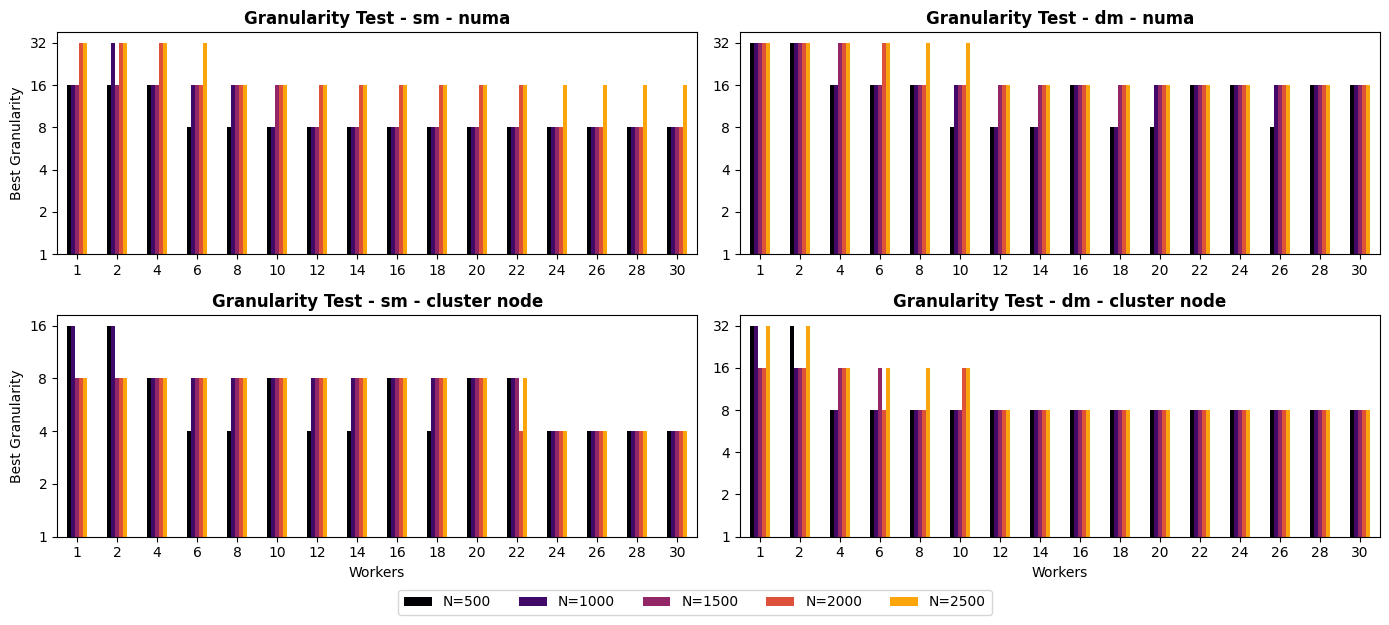

In [6]:
colors = plt.cm.inferno(np.linspace(0, 0.8, len(GRAN_DIM)))  # Using a colormap to generate distinct colors

fig, axs = plt.subplots(len(MACHINE_ID), len(MAT_F), figsize=(14, len(MACHINE_ID) * 3))
handles = []

for i, key in enumerate(MACHINE_ID):
    for l, mat_f in enumerate(MAT_F):
        plot = {} # Initialize the plot dictionary for each subplot
        ax = axs[i][l]
        for k, dim in enumerate(GRAN_DIM):
        
            
            filename = 'ff_s_' + mat_f + '_g'
            df = logs[filename].loc[(dim, key)]
            df = df.droplevel(df.index.names[:-2]).reset_index()
            df['log_g'] = np.log2(df['granularity'])
            grouped = df.loc[df.groupby('num_workers')['running_time'].idxmin()][['num_workers', 'log_g']].set_index(
                'num_workers').rename(columns={'log_g': f'N={dim}'})

            plot[f'N={dim}'] = [x for x in grouped[f'N={dim}'].values]

        df_plot = pd.DataFrame(plot)
        bars = df_plot.plot(ax=ax, kind='bar', color=[colors[j] for j in range(len(df_plot.columns))])

        ax.set_xticks(range(len(grouped.index)))
        ax.set_xticklabels(grouped.index, rotation=0)
        ax.set_yticklabels([2**x for x in range(len(ax.get_yticks()))])
        
        ax.legend().set_visible(False)
            
        if l == 0:
            ax.set_ylabel('Best Granularity')
        if i == len(MACHINE_ID) - 1:
            ax.set_xlabel('Workers')
        ax.set_title(f'Granularity Test - {mat_f} - {MACHINE_ID[key]}', fontweight="bold")


handles, labels = ax.get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, loc='upper center', bbox_to_anchor=(0.5, 0.02), ncol=5);

plt.tight_layout()
plt.savefig(PLOT_DIR / 'granularity_analysis.png')

## Strong Scalability

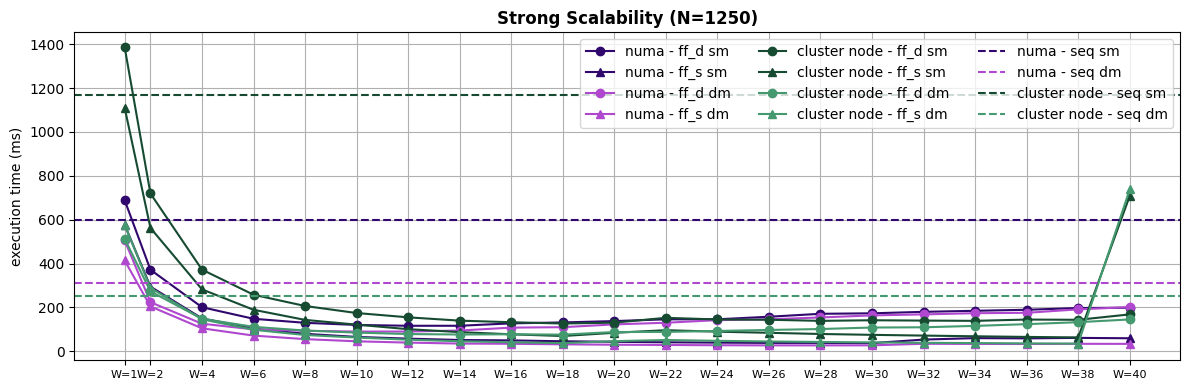

In [7]:

# Creating the figure and subplot
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

# Define x-values for the plot
xvalues = [1] + [x for x in range(2, 41, 2)]

# Iterate over MACHINE_ID, MAT_F, and PROG_F
for i, key in enumerate(MACHINE_ID):
    for l, mat_f in enumerate(MAT_F):
        for k, prog_f in enumerate(PROG_F[1:]):
            filename = prog_f + '_' + mat_f
            if prog_f == PROG_F[1]:
                ind = [(DEFAULT_N, key, DEFAULT_DEBUG, x) for x in xvalues]
            else:
                ind = [(DEFAULT_N, key, DEFAULT_DEBUG, x, DEFAULT_G[key]) for x in xvalues]
            ax.plot(
                logs[filename].loc[ind].reset_index()['num_workers'].values,
                logs[filename].loc[ind].reset_index()['running_time'].values,
                MERKERS[k],
                label=f'{MACHINE_ID[key]} - {prog_f} {mat_f}',
                color=PALETTE[i][l * 2]
            )

# Plot sequential baseline for each MACHINE_ID and MAT_F
for i, key in enumerate(MACHINE_ID):
    for l, mat_f in enumerate(MAT_F):
        filename = 'seq_' + mat_f
        ind = [(DEFAULT_N, key, DEFAULT_DEBUG)]
        ax.axhline(
            y=logs[filename].loc[ind].reset_index()['running_time'].values,
            color=PALETTE[i][l * 2],
            linestyle='--',
            label=f'{MACHINE_ID[key]} - seq {mat_f}'
        )

# Set x-axis ticks and labels
labels = [f'W={y}' for y in xvalues]
ax.set_xticks(xvalues)
ax.set_xticklabels(labels, fontsize=SMALL_FONT)

# Set y-axis label and legend
ax.set_ylabel("execution time (ms)")
ax.legend(fontsize=NORMAL_FONT, ncol=3)

# Set y-axis scale to logarithmic, add grid, and set title
# ax.set_yscale('log')
ax.grid()
ax.set_title(
    f'Strong Scalability (N={DEFAULT_N})',
    fontweight="bold"
)

# Adjust layout
plt.tight_layout()
plt.savefig(PLOT_DIR / 'strong_scalability.png')

# Display the plot
plt.show()


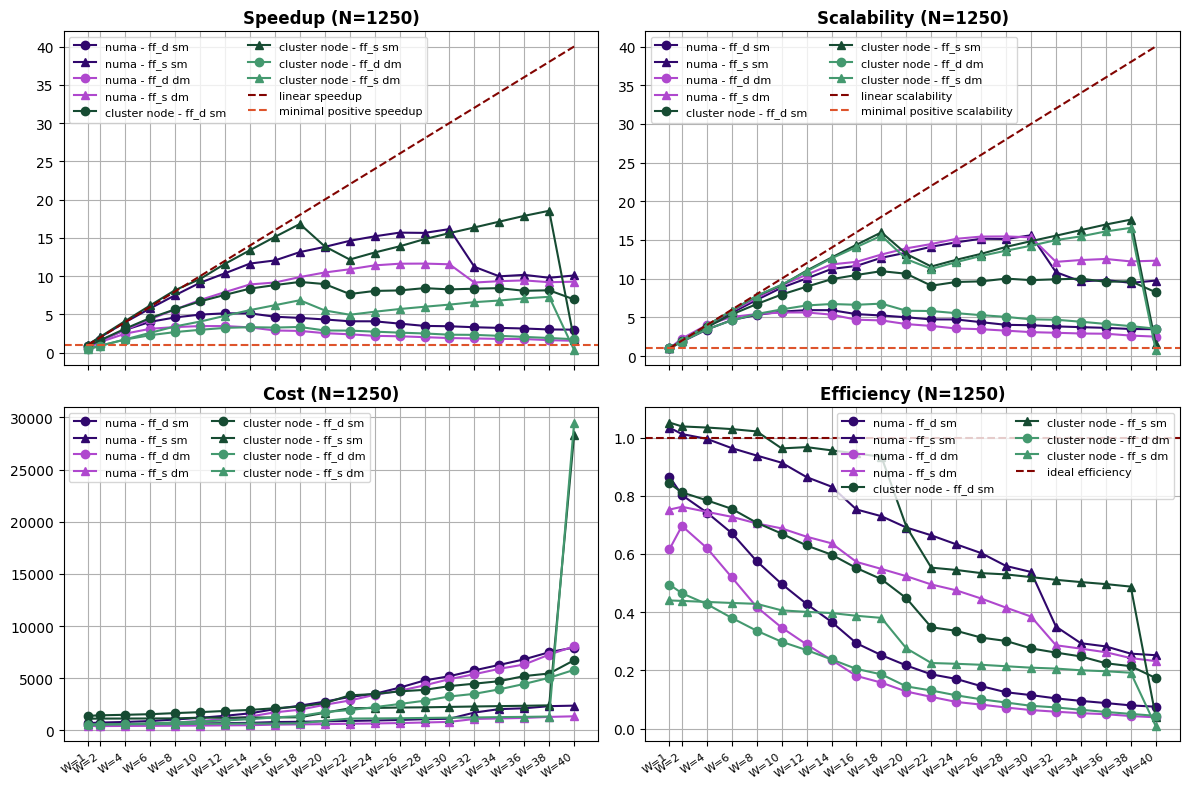

In [8]:
import matplotlib.pyplot as plt

# Create figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Define x-values for the plot
xvalues = [1] + [x for x in range(2, 41, 2)]


# Iterate over metrics to plot
for j, col in enumerate(METRICS):
    ax = axs[int(j / 2), j % 2]
    
    # Plot data for each MACHINE_ID, MAT_F, and PROG_F combination
    for i, key in enumerate(MACHINE_ID):
        for l, mat_f in enumerate(MAT_F):
            for k, prog_f in enumerate(PROG_F[1:]):
                filename = prog_f + '_' + mat_f
                if prog_f == PROG_F[1]:
                    ind = [(DEFAULT_N, key, DEFAULT_DEBUG, x) for x in xvalues]
                else:
                    ind = [(DEFAULT_N, key, DEFAULT_DEBUG, x, DEFAULT_G[key]) for x in xvalues]
                ax.plot(
                    logs[filename].loc[ind].reset_index()['num_workers'].values,
                    logs[filename].loc[ind].reset_index()[col].values,
                    MERKERS[k],
                    label=f'{MACHINE_ID[key]} - {prog_f} {mat_f}',
                    color=PALETTE[i][l * 2]
                )
    
    # Set title and x-axis ticks/labels
    ax.set_title(f'{col.capitalize()} (N={DEFAULT_N})', fontweight="bold")
    ax.set_xticks(xvalues)
    
    # Adjust x-axis labels for readability
    if j >= 2:
        labels = [f'W={y}' for y in xvalues]
        ax.set_xticklabels(labels, fontsize=8, rotation=35)
        for label in ax.get_xticklabels():
            label.set_horizontalalignment('right')
    else:
        ax.set_xticklabels([])
    
    # Add annotations for specific lines
    if j == 0:
        ax.plot(ax.get_xticks(), ax.get_xticks(),
                '--', label='linear speedup', color=ORANGE_PALETTE[0])
        ax.axhline(y=1, label='minimal positive speedup', linestyle='--', color=ORANGE_PALETTE[2])
    elif j == 1:
        ax.plot(ax.get_xticks(), ax.get_xticks(),
                '--', label='linear scalability', color=ORANGE_PALETTE[0])
        ax.axhline(y=1, label='minimal positive scalability', linestyle='--', color=ORANGE_PALETTE[2])
    elif j == 3:
        ax.axhline(y=1, label='ideal efficiency', linestyle='--', color=ORANGE_PALETTE[0])
    
    # Set plot configurations
    ax.legend(fontsize=SMALL_FONT, ncol=2)
    ax.grid()
    #ax.set_yscale('log')

# Adjust layout and display the plot
plt.tight_layout()
plt.savefig(PLOT_DIR / 'strong_scalability_metrics.png')
plt.show()


## Weak Scalability - quadratic increase

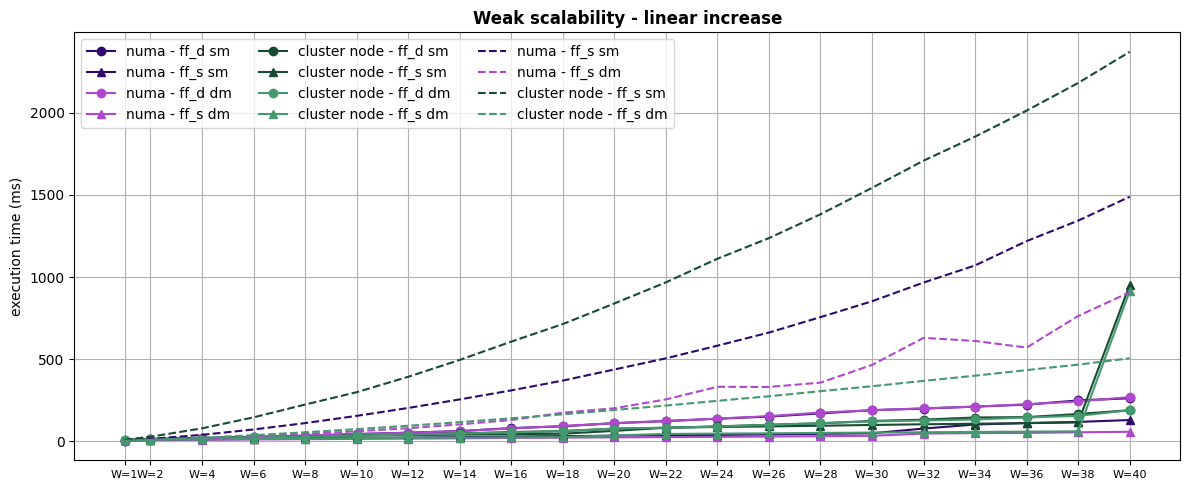

In [9]:
# Creazione della figura e dei sottotrame
fig, ax = plt.subplots(1, 1, figsize=(12, 5))


xvalues = [1] + [x for x in range(2,41,2)]

for i, key in enumerate(MACHINE_ID):
    for l, mat_f in enumerate(MAT_F): 
        for k, prog_f in enumerate(PROG_F[1:]):
            filename = prog_f + '_' + mat_f
            if prog_f == PROG_F[1]: ind = [(int(math.sqrt(STEP_2N * x)), key, DEFAULT_DEBUG, x) for x in  xvalues]
            else: ind = [(int(math.sqrt(STEP_2N * x)), key, DEFAULT_DEBUG, x, DEFAULT_G[key]) for x in  xvalues]
            ax.plot(logs[filename].loc[ind].reset_index()['num_workers'].values,
                    logs[filename].loc[ind].reset_index()['running_time'].values, 
                    MERKERS[k],
                    label=f'{MACHINE_ID[key]} - {prog_f} {mat_f}',
                    color=PALETTE[i][l*2])
            
for i, key in enumerate(MACHINE_ID):
    for l, mat_f in enumerate(MAT_F): 
        filename = 'seq_' + mat_f
        ind = [(int(math.sqrt(STEP_2N * x)), key, DEFAULT_DEBUG) for x in  xvalues]
        ax.plot(xvalues,
                    logs[filename].loc[ind].reset_index()['running_time'].values, 
                    '--',
                    label=f'{MACHINE_ID[key]} - {prog_f} {mat_f}',
                    color=PALETTE[i][l*2])
        
labels = [f'W={y}' for y in xvalues] 
ax.set_xticks(xvalues)
ax.set_xticklabels(labels, fontsize=SMALL_FONT)

ax.set_ylabel("execution time (ms)")
ax.legend(fontsize=NORMAL_FONT, ncol=3)
#ax.set_yscale('log')
ax.grid()
ax.set_title(
    f'Weak scalability - linear increase',
    fontweight="bold"
)

plt.tight_layout()

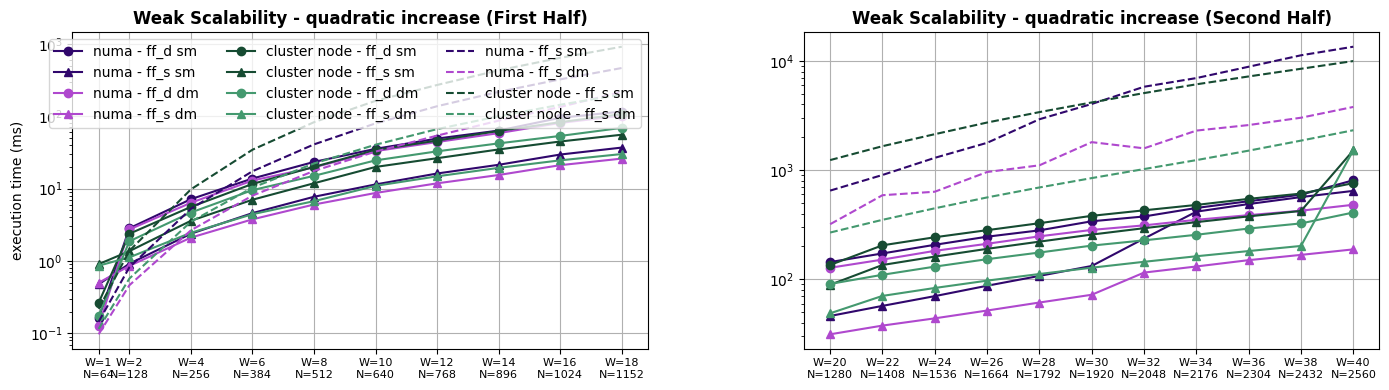

In [10]:
import matplotlib.pyplot as plt

# Creazione della figura e dei sottotrame
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Intervalli
xvalues = [1] + [x for x in range(2, 41, 2)]
midpoint = len(xvalues) // 2
first_half = xvalues[:midpoint]
second_half = xvalues[midpoint:]

for i, key in enumerate(MACHINE_ID):
    for l, mat_f in enumerate(MAT_F): 
        for k, prog_f in enumerate(PROG_F[1:]):
            filename = prog_f + '_' + mat_f
            if prog_f == PROG_F[1]: 
                ind_first = [(STEP_N * x, key, DEFAULT_DEBUG, x) for x in first_half]
                ind_second = [(STEP_N * x, key, DEFAULT_DEBUG, x) for x in second_half]
            else: 
                ind_first = [(STEP_N * x, key, DEFAULT_DEBUG, x, DEFAULT_G[key]) for x in first_half]
                ind_second = [(STEP_N * x, key, DEFAULT_DEBUG, x, DEFAULT_G[key]) for x in second_half]

            ax1.plot(logs[filename].loc[ind_first].reset_index()['num_workers'].values,
                     logs[filename].loc[ind_first].reset_index()['running_time'].values, 
                     MERKERS[k],
                     label=f'{MACHINE_ID[key]} - {prog_f} {mat_f}',
                     color=PALETTE[i][l * 2])
            
            ax2.plot(logs[filename].loc[ind_second].reset_index()['num_workers'].values,
                     logs[filename].loc[ind_second].reset_index()['running_time'].values, 
                     MERKERS[k],
                     label=f'{MACHINE_ID[key]} - {prog_f} {mat_f}',
                     color=PALETTE[i][l * 2])

for i, key in enumerate(MACHINE_ID):
    for l, mat_f in enumerate(MAT_F): 
        filename = 'seq_' + mat_f
        ind_first = [(STEP_N * x, key, DEFAULT_DEBUG) for x in first_half]
        ind_second = [(STEP_N * x, key, DEFAULT_DEBUG) for x in second_half]
        
        ax1.plot(first_half,
                 logs[filename].loc[ind_first].reset_index()['running_time'].values, 
                 '--',
                 label=f'{MACHINE_ID[key]} - {prog_f} {mat_f}',
                 color=PALETTE[i][l * 2])
        
        ax2.plot(second_half,
                 logs[filename].loc[ind_second].reset_index()['running_time'].values, 
                 '--',
                 label=f'{MACHINE_ID[key]} - {prog_f} {mat_f}',
                 color=PALETTE[i][l * 2])

# Impostazioni asse x e legenda per il primo sottografico
labels_first = [f'W={y}\nN={STEP_N*y}' for y in first_half] 
ax1.set_xticks(first_half)
ax1.set_xticklabels(labels_first, fontsize=SMALL_FONT)
ax1.set_ylabel("execution time (ms)")
ax1.legend(fontsize=NORMAL_FONT, ncol=3)
ax1.set_yscale('log')
ax1.grid()
ax1.set_title('Weak Scalability - quadratic increase (First Half)', fontweight="bold")

# Impostazioni asse x e legenda per il secondo sottografico
labels_second = [f'W={y}\nN={STEP_N*y}' for y in second_half] 
ax2.set_xticks(second_half)
ax2.set_xticklabels(labels_second, fontsize=SMALL_FONT)
ax2.set_yscale('log')
ax2.grid()
ax2.set_title('Weak Scalability - quadratic increase (Second Half)', fontweight="bold")

plt.tight_layout()
plt.savefig(PLOT_DIR / 'quadratic_weak_scalability_divided.png')
plt.show()


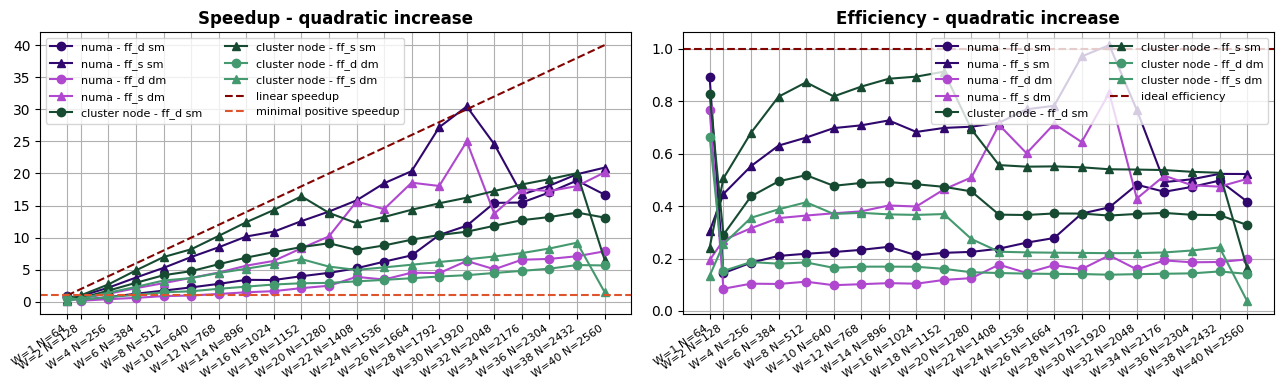

In [11]:
# Creazione della figura e dei sottotrame
fig, axs = plt.subplots(1, 2, figsize=(13, 4))

xvalues = [1] + [x for x in range(2,41,2)]
for j, col in enumerate(METRICS[:1] + METRICS[-1:]):
    ax = axs[j]
    for i, key in enumerate(MACHINE_ID):
        for l, mat_f in enumerate(MAT_F): 
            for k, prog_f in enumerate(PROG_F[1:]):
                filename = prog_f + '_' + mat_f
                if prog_f == PROG_F[1]: ind = [(STEP_N*x, key, DEFAULT_DEBUG, x) for x in  xvalues]
                else: ind = [(STEP_N*x, key, DEFAULT_DEBUG, x, DEFAULT_G[key]) for x in  xvalues]
                ax.plot(logs[filename].loc[ind].reset_index()['num_workers'].values,
                        logs[filename].loc[ind].reset_index()[col].values, 
                        MERKERS[k],
                        label=f'{MACHINE_ID[key]} - {prog_f} {mat_f}',
                        color=PALETTE[i][l*2])
                
    ax.set_title(
        f'{col.capitalize()} - quadratic increase',
        fontweight="bold"
    )
    
    ax.set_xticks(xvalues)

    labels = [f'W={y} N={STEP_N*y}' for y in xvalues] 
    ax.set_xticklabels(labels, fontsize=8, rotation=35)
    for label in ax.get_xticklabels():
        label.set_horizontalalignment('right')

        
axs[0].plot(axs[0].get_xticks(), axs[0].get_xticks(), 
                    '--',
                    label=f'linear speedup',
                    color=ORANGE_PALETTE[0])

axs[0].axhline(y=1,
                label=f'minimal positive speedup',
                 linestyle='--',
                color=ORANGE_PALETTE[2])
axs[1].axhline(y=1,
                label=f'ideal efficiency',
                 linestyle='--',
                color=ORANGE_PALETTE[0])

for l in range(2):
    ax = axs[l]
    ax.legend(fontsize=SMALL_FONT, ncol=2)
    ax.grid()
    #ax.set_yscale('log')
    
plt.tight_layout()
plt.savefig(PLOT_DIR / 'quadratic_weak_scalability_metrics.png')

## Weak Scalability - linear increase

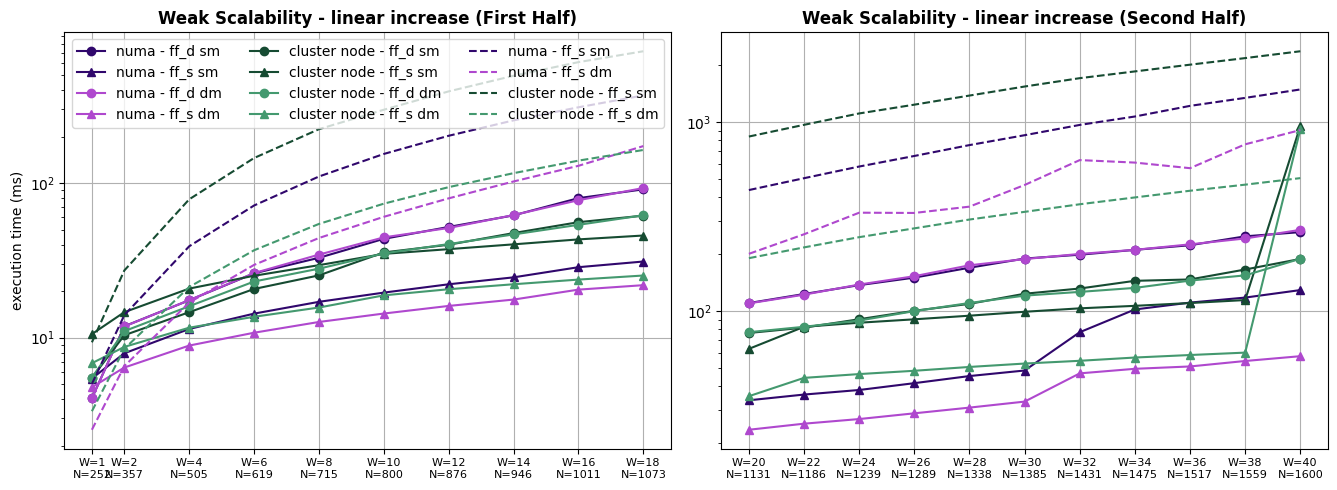

In [12]:
import matplotlib.pyplot as plt

# Creazione della figura e dei sottotrame
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Intervalli
xvalues = [1] + [x for x in range(2, 41, 2)]
midpoint = len(xvalues) // 2
first_half = xvalues[:midpoint]
second_half = xvalues[midpoint:]

for i, key in enumerate(MACHINE_ID):
    for l, mat_f in enumerate(MAT_F): 
        for k, prog_f in enumerate(PROG_F[1:]):
            filename = prog_f + '_' + mat_f
            if prog_f == PROG_F[1]: 
                ind_first = [(int(math.sqrt(STEP_2N * x)), key, DEFAULT_DEBUG, x) for x in first_half]
                ind_second = [(int(math.sqrt(STEP_2N * x)), key, DEFAULT_DEBUG, x) for x in second_half]
            else: 
                ind_first = [(int(math.sqrt(STEP_2N * x)), key, DEFAULT_DEBUG, x, DEFAULT_G[key]) for x in first_half]
                ind_second = [(int(math.sqrt(STEP_2N * x)), key, DEFAULT_DEBUG, x, DEFAULT_G[key]) for x in second_half]

            ax1.plot(logs[filename].loc[ind_first].reset_index()['num_workers'].values,
                     logs[filename].loc[ind_first].reset_index()['running_time'].values, 
                     MERKERS[k],
                     label=f'{MACHINE_ID[key]} - {prog_f} {mat_f}',
                     color=PALETTE[i][l * 2])
            
            ax2.plot(logs[filename].loc[ind_second].reset_index()['num_workers'].values,
                     logs[filename].loc[ind_second].reset_index()['running_time'].values, 
                     MERKERS[k],
                     label=f'{MACHINE_ID[key]} - {prog_f} {mat_f}',
                     color=PALETTE[i][l * 2])

for i, key in enumerate(MACHINE_ID):
    for l, mat_f in enumerate(MAT_F): 
        filename = 'seq_' + mat_f
        ind_first = [(int(math.sqrt(STEP_2N * x)), key, DEFAULT_DEBUG) for x in first_half]
        ind_second = [(int(math.sqrt(STEP_2N * x)), key, DEFAULT_DEBUG) for x in second_half]
        
        ax1.plot(first_half,
                 logs[filename].loc[ind_first].reset_index()['running_time'].values, 
                 '--',
                 label=f'{MACHINE_ID[key]} - {prog_f} {mat_f}',
                 color=PALETTE[i][l * 2])
        
        ax2.plot(second_half,
                 logs[filename].loc[ind_second].reset_index()['running_time'].values, 
                 '--',
                 label=f'{MACHINE_ID[key]} - {prog_f} {mat_f}',
                 color=PALETTE[i][l * 2])

# Impostazioni asse x e legenda per il primo sottografico
labels_first = [f'W={y}\nN={int(math.sqrt(STEP_2N * y))}' for y in first_half] 
ax1.set_xticks(first_half)
ax1.set_xticklabels(labels_first, fontsize=SMALL_FONT)
ax1.set_ylabel("execution time (ms)")
ax1.legend(fontsize=NORMAL_FONT, ncol=3)
ax1.set_yscale('log')
ax1.grid()
ax1.set_title('Weak Scalability - linear increase (First Half)', fontweight="bold")

# Impostazioni asse x e legenda per il secondo sottografico
labels_second = [f'W={y}\nN={int(math.sqrt(STEP_2N * y))}' for y in second_half] 
ax2.set_xticks(second_half)
ax2.set_xticklabels(labels_second, fontsize=SMALL_FONT)
ax2.set_yscale('log')
ax2.grid()
ax2.set_title('Weak Scalability - linear increase (Second Half)', fontweight="bold")

plt.tight_layout()
plt.savefig(PLOT_DIR / 'linear_weak_scalability_divided.png')

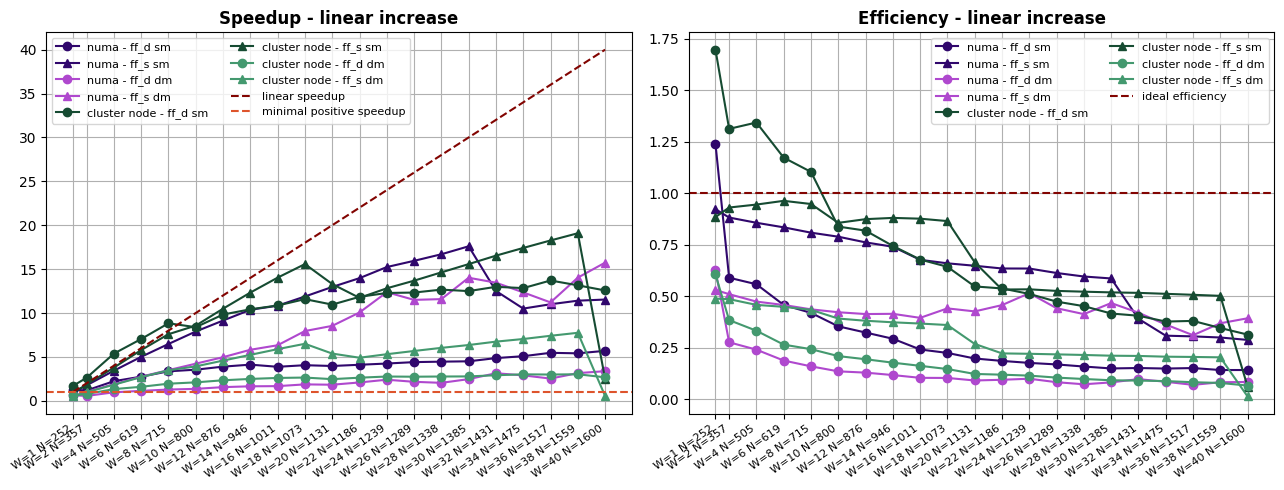

In [13]:
# Creazione della figura e dei sottotrame
fig, axs = plt.subplots(1, 2, figsize=(13, 5))

xvalues = [1] + [x for x in range(2,41,2)]
for j, col in enumerate(METRICS[:1] + METRICS[-1:]):
    ax = axs[j]
    for i, key in enumerate(MACHINE_ID):
        for l, mat_f in enumerate(MAT_F): 
            for k, prog_f in enumerate(PROG_F[1:]):
                filename = prog_f + '_' + mat_f
                if prog_f == PROG_F[1]: 
                    ind = [(int(math.sqrt(STEP_2N * x)), key, DEFAULT_DEBUG, x) for x in xvalues]
                else: 
                    ind = [(int(math.sqrt(STEP_2N * x)), key, DEFAULT_DEBUG, x, DEFAULT_G[key]) for x in xvalues]
                ax.plot(logs[filename].loc[ind].reset_index()['num_workers'].values,
                        logs[filename].loc[ind].reset_index()[col].values, 
                        MERKERS[k],
                        label=f'{MACHINE_ID[key]} - {prog_f} {mat_f}',
                        color=PALETTE[i][l*2])
                
    ax.set_title(
        f'{col.capitalize()} - linear increase',
        fontweight="bold"
    )
    
    ax.set_xticks(xvalues)

    labels = [f'W={y} N={int(math.sqrt(STEP_2N * y))}' for y in xvalues] 
    ax.set_xticklabels(labels, fontsize=8, rotation=35)
    for label in ax.get_xticklabels():
        label.set_horizontalalignment('right')

        
axs[0].plot(axs[0].get_xticks(), axs[0].get_xticks(), 
                    '--',
                    label=f'linear speedup',
                    color=ORANGE_PALETTE[0])

axs[0].axhline(y=1,
                label=f'minimal positive speedup',
                 linestyle='--',
                color=ORANGE_PALETTE[2])
axs[1].axhline(y=1,
                label=f'ideal efficiency',
                 linestyle='--',
                color=ORANGE_PALETTE[0])

for l in range(2):
    ax = axs[l]
    ax.legend(fontsize=SMALL_FONT, ncol=2)
    ax.grid()
    # ax.set_yscale('log')
    
plt.tight_layout()
plt.savefig(PLOT_DIR / 'linear_weak_scalability_metrics.png')